# Are you still diversifying using the Markowitz model? Welcome to the 21st century.

This article is Part 1 of a series of articles on Diversification.

Most retail traders aka "dumb money" don't diversify.

Contrastingly, professional portfolio managers diversify:

1. across markets;
2. across sectors;
3. across asset types;
4. across investment strategies.

Professional portfolio managers are more afraid of the occasional downswings and crashes than retails traders are. And rightly so. The best managers monitor their exposure and seek to re-balance it to according to their perceived optimum portfolio weights. They understand that diversification is key to minimizing risk.


The most popular, most used model for calculating the optimal portfolio weights is the Markowitz model and the Efficient Frontier.  
**This is now considered ancient technology.**

There are 2 main issues with the Markowitz Model:
1. **Markowitz is always overfitting the training data.**. 
    
    Markowitz's result was an optimization process for the weights that would have been profitable in the past. Markowitz model is not learning a set of rules for predicting the future. Instead, this model can be summed up as "Has this portfolio worked well in the past 10 years? Then it is sure to work well for the next 10!". You can change the 10 year for whatever timestep you like - you'll still be overfitting.
    
    
    
2. **It finds the weights that maximize Sharpe ratio. Sharpe ratio sucks.**
    
    > "What?! But everybody is using Sharpe ratio!"
    
    Using Sharpe for showcasing portfolio metrics to clients is ok; using it for daily quant work is not ok. Sharpe ratio's denominator is the standard deviation of returns, which is a good measure of variability, not a good measure of risk. Sharpe ratio penalizes large positive swings, penalizes accelerating returns, and fails to penalize deaccelerating returns. For experimental evidence, see: https://www.crystalbull.com/sharpe-ratio-better-with-log-returns/

# Enter Machine Learning.

There are several ways we can frame the problem of portfolio optimization as a Machine Learning problem:

1. **Reinforcement Learning**: learning the optimal increase/decrease in portfolio weights.

2. **Supervised Learning**: learning the optimal portfolio weights for the next N days/months/years.

3. **Unsupervised Learning**: learning clusters of assets, according to their price and fundamentals similarity.

Today, I will focus on the latter problem. Learning groups of assets can identify how to diversify according to historical data.

We will be starting with the following dataset:

In [1]:
cd ..

/home/quebralim/Documents/qualitative-clustering


In [2]:
import pandas as pd

data = pd.read_csv("data/stocks.csv")
data

,year,ticker,returns_yoy,returns_mean,returns_std,returns_kurt,returns_skew,current_assets_chg,total_assets_chg,current_liabilities_chg,...,gross_profit_chg,operating_income_chg,ebit_chg,ebitda_chg,net_income_chg,cash_flow_chg,gics_sector,gics_industry_group,gics_industry,gics_sub_industry
0,1984,ABT,-0.023327,-0.000081,0.015751,1.137280,0.150682,0.199012,0.123607,0.192155,...,0.091034,0.119551,0.119551,0.142322,0.158099,0.185255,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
1,1984,ADM,-0.026099,-0.000104,0.020297,3.388723,0.910988,-0.010240,0.016783,-0.442166,...,0.090505,0.239521,0.239521,0.184024,0.068358,0.085822,Consumer Staples,"Food, Beverage & Tobacco",Food Products,Agricultural Products
2,1984,AIR,0.632523,0.002427,0.021781,4.852271,1.239041,0.328328,0.233089,-0.053046,...,0.165023,0.072245,0.072245,0.087333,0.605367,0.327884,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense
3,1984,AP,0.254065,0.001079,0.015319,6.334656,1.158865,0.473669,0.463316,0.484195,...,0.723608,-1.143189,-4.665928,4.393316,-4.411381,2.389767,Materials,Materials,Metals & Mining,Steel
4,1984,APA,0.354090,0.001460,0.023034,1.213794,0.306496,-0.103468,-0.083883,0.176250,...,-0.125055,-0.006917,-0.058889,0.037832,-0.028582,0.121321,Energy,Energy,"Oil, Gas & Consumable Fuels",Oil & Gas Exploration & Production
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16034,2018,XYL,0.438349,0.001772,0.010812,2.641754,-0.159363,0.011106,0.052770,0.262727,...,0.094543,0.197802,0.163511,0.149693,0.658610,0.327869,Industrials,Capital Goods,Machinery,Industrial Machinery
16035,2018,YUM,0.304004,0.001204,0.010132,8.515445,0.365575,-0.518548,-0.222369,-0.139550,...,0.074187,-0.168417,0.040901,-0.024227,0.150746,-0.204243,Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure",Restaurants
16036,2018,ZBH,-0.105038,-0.000394,0.013195,3.860412,-0.492598,-0.030100,-0.072546,-0.219370,...,-0.006197,-0.958179,-0.260979,-0.170304,-1.209064,-0.605724,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
16037,2018,ZEN,0.534857,0.002201,0.022210,3.768737,0.040686,0.664630,1.093239,0.494517,...,0.379028,0.299418,0.299418,0.366408,0.283363,0.346874,Information Technology,Software & Services,Software,Application Software


Each line describes an instance. Each instance contains quantitative information about a given stock for a given year, as well as its GICS sector, industry_group, industry, and sub_industry.

We select the top50 industries with that contain the most instances:

In [3]:
top50 = data.gics_industry.value_counts().iloc[:50]
top50

Machinery                                         1379
Oil, Gas & Consumable Fuels                       1312
Chemicals                                          916
Specialty Retail                                   899
Energy Equipment & Services                        779
Aerospace & Defense                                634
Health Care Equipment & Supplies                   582
Electronic Equipment, Instruments & Components     485
Hotels, Restaurants & Leisure                      480
Food Products                                      463
Metals & Mining                                    452
Commercial Services & Supplies                     424
Health Care Providers & Services                   387
Containers & Packaging                             362
Textiles, Apparel & Luxury Goods                   302
IT Services                                        301
Construction & Engineering                         272
Professional Services                              270
Household 

And filter our data so that we only contain those gics industries.

In [4]:
data = data[data.gics_industry.isin(top50.index)]

And then standardize the numerical information:

In [ ]:
quantitative_vars = data.select_dtypes('number').columns
quantitative_data = data.loc[:, quantitative_vars]
data.loc[:, quantitative_vars] = (quantitative_data - quantitative_data.mean()) / quantitative_data.std()

We can now calculate and visualize the dissimilarity between industries, measured by the [Maximum Mean Discrepancy](http://jmlr.csail.mit.edu/papers/v13/gretton12a.html) between the samples of the different industries).

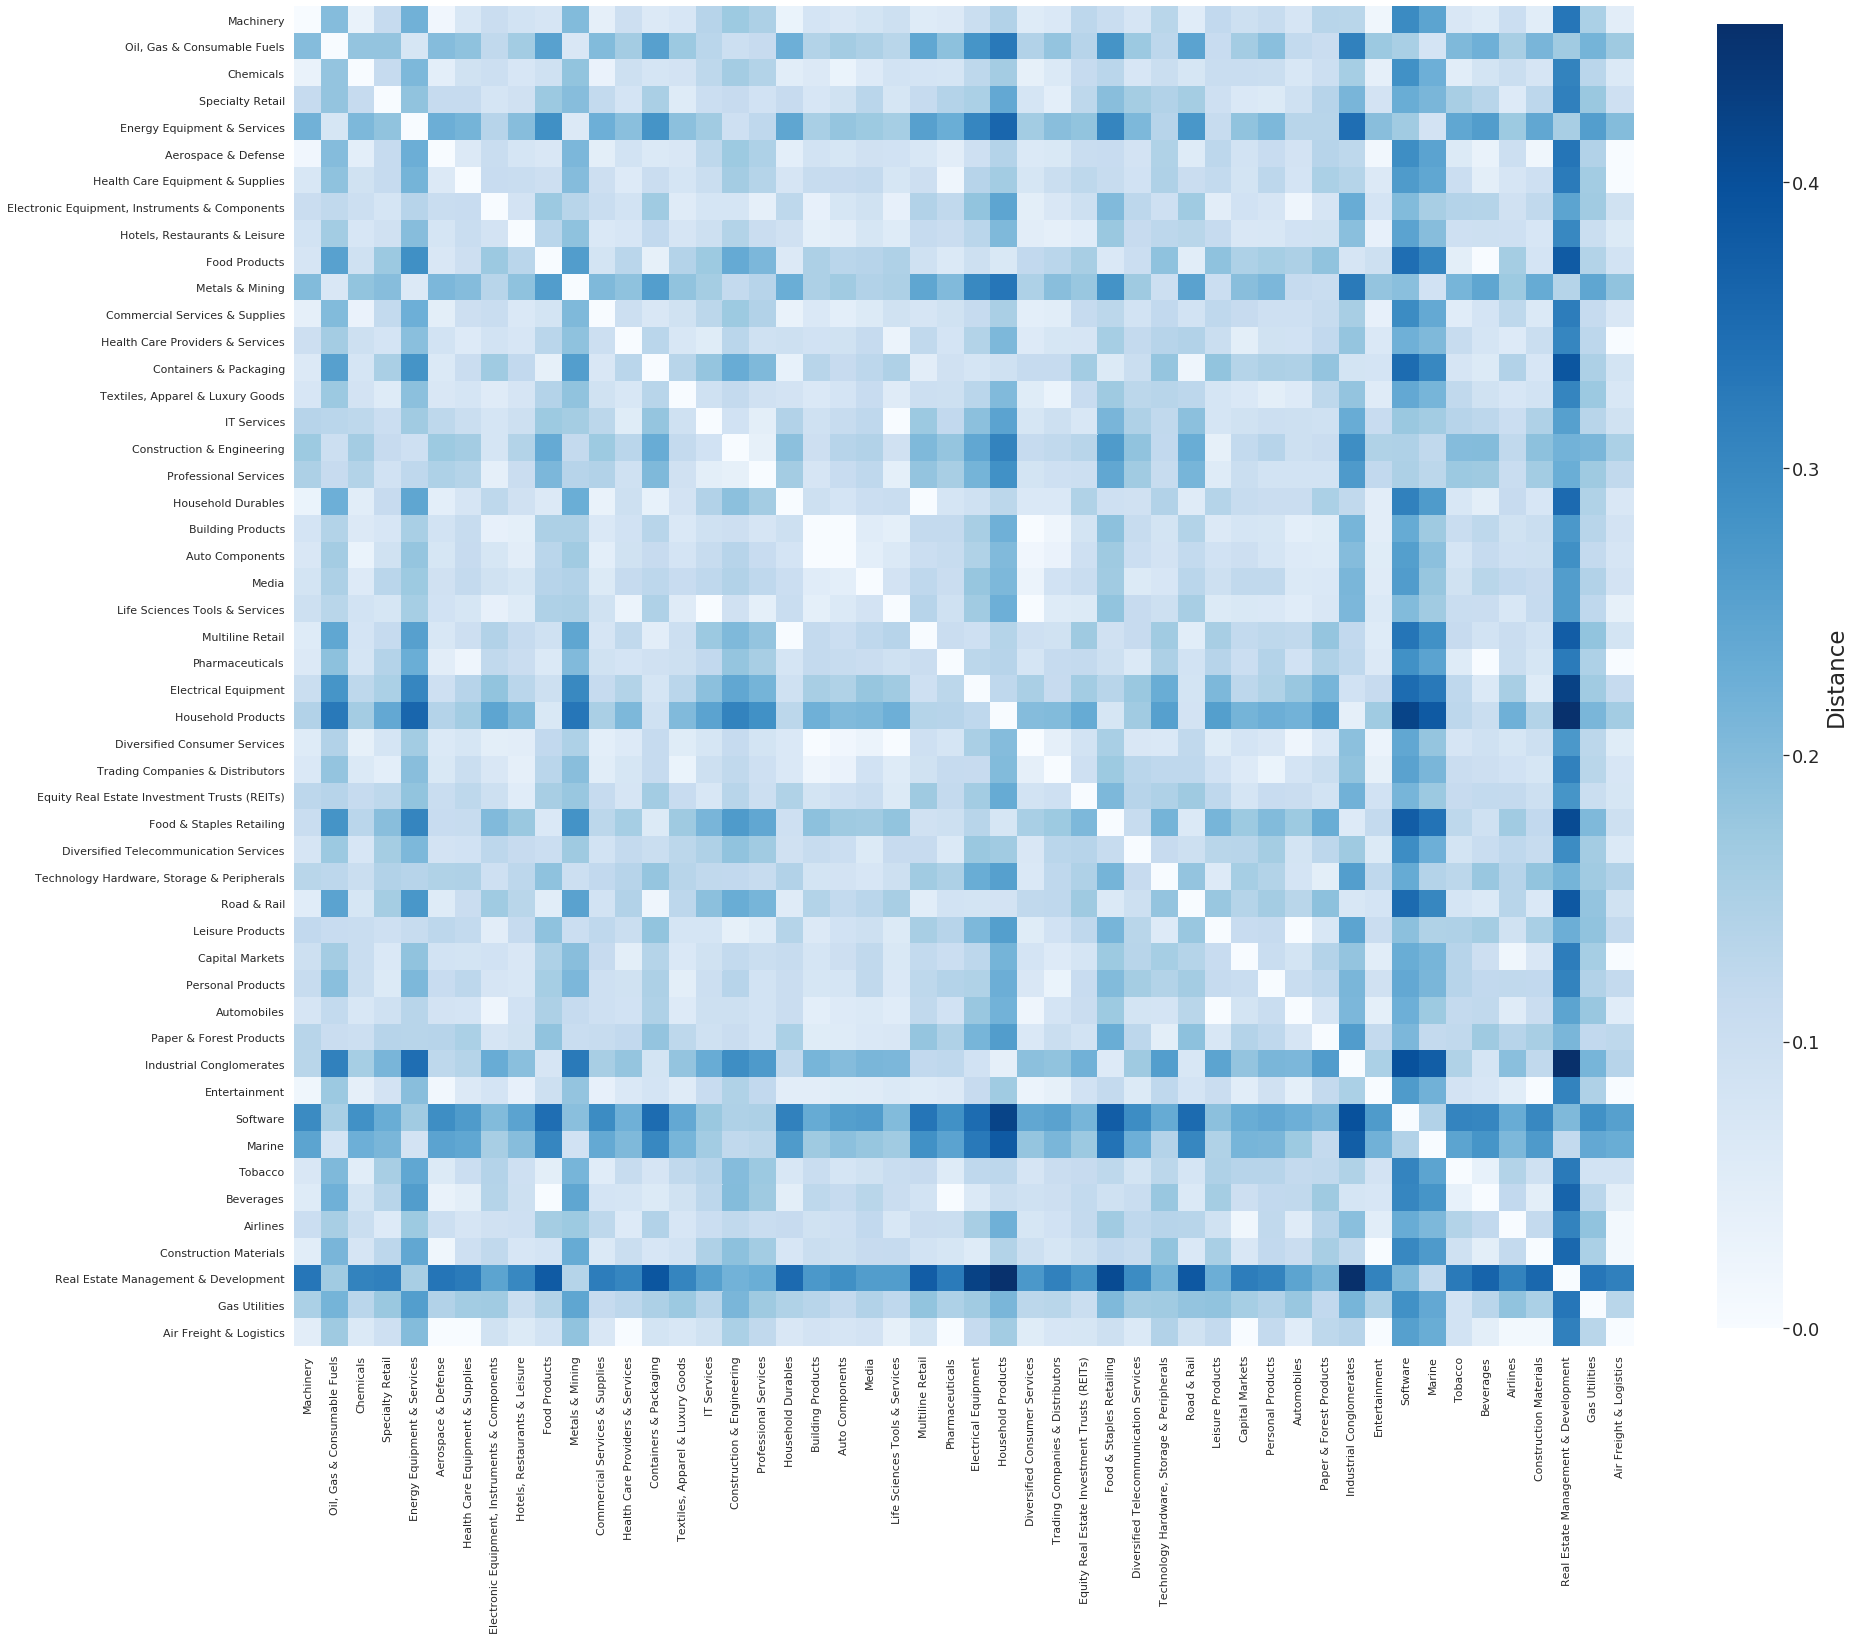

In [15]:
from qclustering import dissimilarity_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

dmatrix = dissimilarity_matrix(data, 'gics_industry')

fig, ax = plt.subplots(figsize=(30,30))
cbar_kws = cbar_kws={'shrink': .8, 'label':'Distance'}
sns.heatmap(dmatrix, ax=ax, vmin=0, square=True, cmap='Blues', cbar_kws=cbar_kws)
fig.axes[-1].yaxis.label.set_size(23)
fig.axes[-1].tick_params(labelsize=18)

We can also frame this as a Hierarchical Clustering problem and use MMD as a linkage metric between industries and clusters of industries:

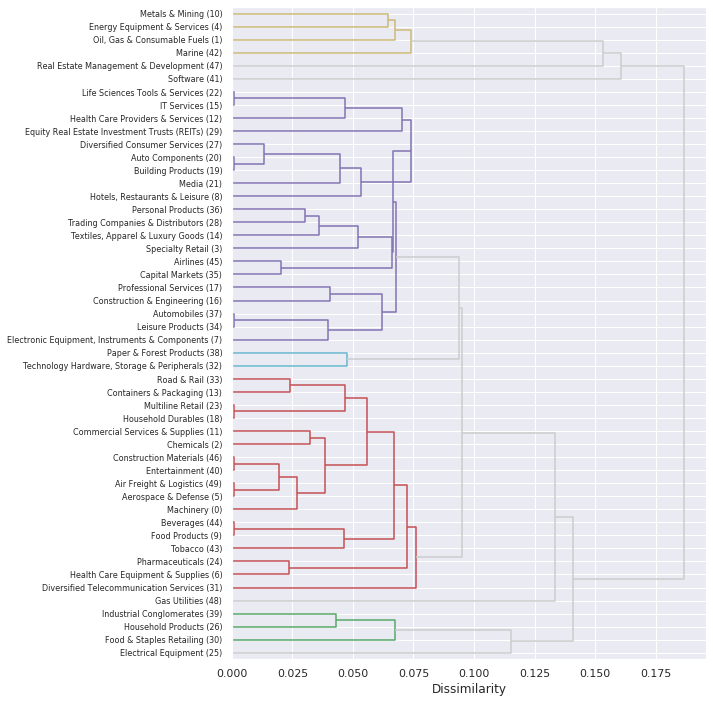

In [16]:
from qclustering import hierarchical_clustering, plot_dendrogram
initial_clusters, linkage = hierarchical_clustering(data, 'gics_industry')
plot_dendrogram(initial_clusters, linkage, color_threshold=0.09, above_threshold_color='#CCCCCC');

Based on the chart above, we can see that some industries are being clustered with industries of different sectors. Therefor, the data indicates that we're better off diversifying by industries than diversifying by sectors.
  
  
---
  
  
This concludes Part 1.

In Part 2, we will look at ML-based diversification strategies at compare their foward testing / out-of-sampling results, including some methods from the [MlFinLab python package](https://github.com/hudson-and-thames/mlfinlab).